# E1. Localization

### Define all the imports
Import all the dependencies required to launch the notebook

In [1]:
# Import main dependencies
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [2]:
# Change to main repo folder for the imports
_, dir = os.path.split(os.getcwd())
if dir == 'notebooks': 
    os.chdir('..')
    sys.path.append(os.getcwd())
# Ignore warnings from pandas
pd.set_option('mode.chained_assignment', None)

In [3]:
# Import methods from our local library
from src.localization.PF import ParticleFilter
from src.localization.EKF import ExtendedKalmanFilter

### Set dataset

In [4]:
# Define the dataset to be used for the following tests. 
dataset = "data/MRCLAM_Dataset4" # Dataset
end_frame = 10000 # Extension of the dataset
robot = 'Robot5' # Robot

### T1. Review EKF localization
Review the ExtendedKalmanFilter() method, execute the EKF localization of the next code block, and answer the questions below:

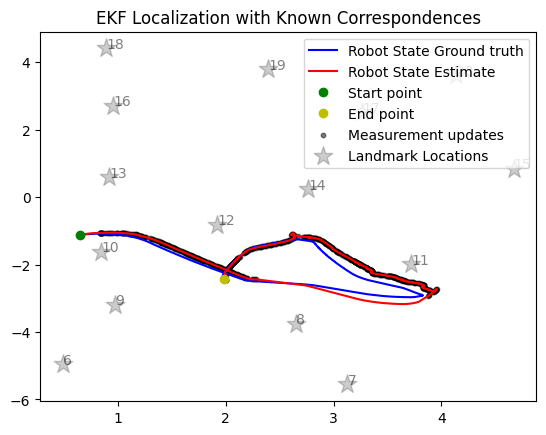

In [5]:
# Build Extended Kalman Filter object
R = np.diagflat(np.array([1.0, 1.0, 10.0]))** 2
Q = np.diagflat(np.array([300, 300, 1e16]))** 2
ekf = ExtendedKalmanFilter(dataset, robot, end_frame, R, Q)

**T11** The EKF localisation algorithm iteratively executes the functions motion_update() and measurement_update() to propagate the robot's state estimate. Could you specify, respectively for each of the two functions, when they are called and what their purpose is?

<span style=color:red>**Answer:**</span> The robot has two different sources of data - its odometry and the measurement data from the sensors. Both these data sources are combined into a single dataframe called "data" sorted by time. Each of them are separated by a subject flag which is -1 in case of odometry. The EKF localization algorithm executes the motion_update() function when the input data is from odometry, and measurement_update() otherwise.

The *motion_update()* function receives the odometry information as the linear and angular velocity applied as control inputs. When two control inputs are adequately far apart, the algorithm estimates new states (x, y, theta) from its last states.

The *measurement_update()* function receives measurements as range and bearing to landmarks. The algorithm first estimates the expected ranges and bearings of landmarks based on their last states and calculates the deviation from the range and bearing from the ground-truth data. Based on this information, the algorithm estimates the corrected state.

**T12** The ExtendedKalmanFilter() method inputs the R and Q matrices. Could you describe what are they used for and how they affect to the resulting localization estimation?

<span style=color:red>**Answer:**</span> The parameters R and Q represent the state and the measurement covariance matrices respectively. R<sub>t</sub> is a function of the linear and angular velocities of the corresponding control input [v<sub>t</sub>,w<sub>t</sub>] for the same timestep and the mean from the last timestep. It is used in the motion_update() function for updating the sigma covariance. On the other hand, Q is a function of the variances of measurement noises. Q is used in the measurement_update() to update the Kalman gain. 

Hence, an R matrix with smaller values will result in a noisier motion model and less confidence in the control inputs. Contrastingly, a smaller Q means more noise in the measurement model, hence, the state will be more influenced by the control inputs.

### T2. Review PF localization
Review the ParticleFilter() method, execute the PF localization of the next code block, and answer the questions below:

time for 1 particle: 1.67 sec.


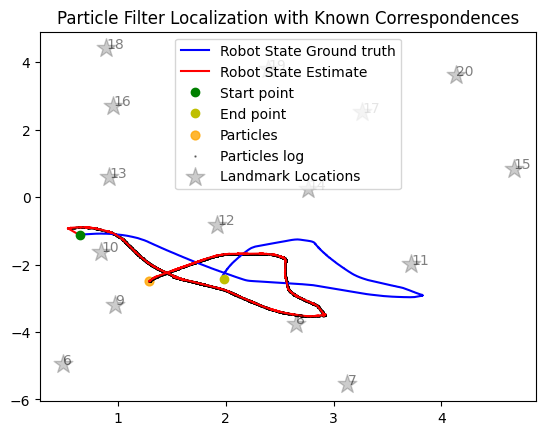

In [6]:
# Build Particle Filter object
num_particles = 1
motion_noise = np.array([0.1, 0.1, 0.1, 0.2, 0.2]) # Motion model noise [noise_x, noise_y, noise_theta, noise_v, noise_w]
measurement_noise = np.array([0.1, 0.1]) # Measurement model noise (in meters / rad) [noise_range, noise_bearing]
start = time.perf_counter()
pf = ParticleFilter(dataset, robot, end_frame, num_particles, motion_noise, measurement_noise)
print(f'time for {num_particles} particle: {time.perf_counter() - start:.2f} sec.')

time for 10 particle: 10.10 sec.


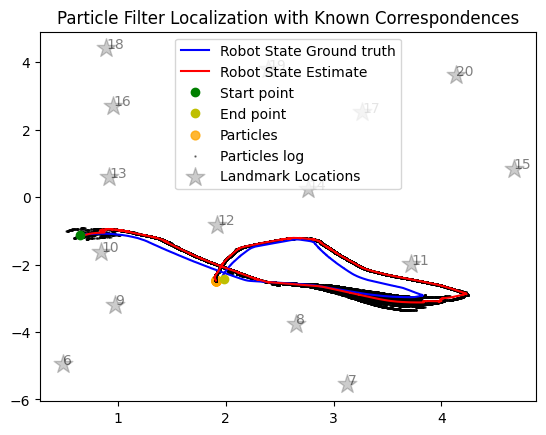

In [8]:
# Build Particle Filter object
num_particles = 10
motion_noise = np.array([0.1, 0.1, 0.1, 0.2, 0.2]) # Motion model noise [noise_x, noise_y, noise_theta, noise_v, noise_w]
measurement_noise = np.array([0.1, 0.1]) # Measurement model noise (in meters / rad) [noise_range, noise_bearing]
start = time.perf_counter()
pf = ParticleFilter(dataset, robot, end_frame, num_particles, motion_noise, measurement_noise)
print(f'time for {num_particles} particle: {time.perf_counter() - start:.2f} sec.')

time for 100 particle: 101.24 sec.


/home/rkibria/.local/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/rkibria/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


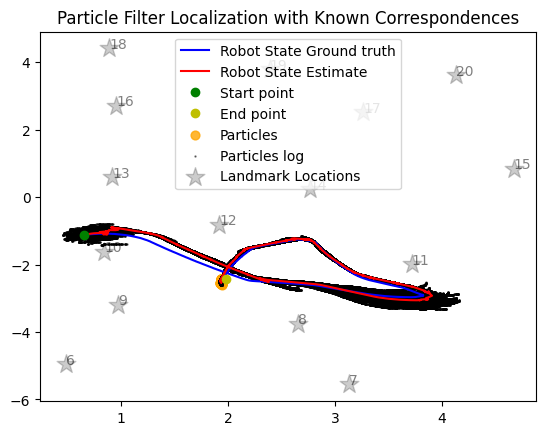

In [9]:
# Build Particle Filter object
num_particles = 100
motion_noise = np.array([0.1, 0.1, 0.1, 0.2, 0.2]) # Motion model noise [noise_x, noise_y, noise_theta, noise_v, noise_w]
measurement_noise = np.array([0.1, 0.1]) # Measurement model noise (in meters / rad) [noise_range, noise_bearing]
start = time.perf_counter()
pf = ParticleFilter(dataset, robot, end_frame, num_particles, motion_noise, measurement_noise)
print(f'time for {num_particles} particle: {time.perf_counter() - start:.2f} sec.')

**T2.1** The PF localisation algorithm iteratively executes the functions motion_update(), measurement_update(), importance_sampling() and state_update(). Could you specify, the objective of each of the functions?

<span style=color:red>**Answer:**</span> The PF localization algorithm applies the *motion_update()* function, like the EKF when there's an input from the odometry of the robot. However, unlike EKF, gaussian noise is applied to the control inputs before updating the state information of each particle (x, y, theta).


The *measurement_update()* function is called when there's a control input (v,w), and it's used to update the weight of importance of the particles. The weight is the joint pdf calculated from the error distributions of range and bearing measurements. The *importance_sampling()* function is called after the measurement update to sample new positions for the particles from this joint pdf of importance weights. Finally, the *state_update()* function estimates the state based on the mean position of all the particles.

**T2.1** The ParticleFilter() method inputs three different configuration parameters: num_particles, motion_noise, measurement_noise. Could you describe what are they used for and how they affect to the resulting localization estimation?

<span style=color:red>**Answer:**</span> 
- *num_particles*: Based on a weight distribution function calculated from the measurement errors, different particles directly contribute to the robot's state estimation. As the number of particles is increased, the variance of the estimated states gets smaller, however, this comes at the expense of more computational resources. From the figures above, as the particles increased, generally, the estimations got more precise at more computation time.
- *motion_noise*: The motion noise consists of noise for both the positions and poses (x, y, theta), and controls (v, w) of particles. These noise values are used to approximate the density function of the position and pose of each particle. The noise in velocity (linear, angular) is used during the motion update to add noise to the control input.
- *measurement_noise*: The measurement noises (n<sub>range</sub>, n<sub>bearing</sub>) are used while generating the joint pdf used for particle redistribution.








### T3. Benchmark
Compare the EKF and the PF algorithms using diferent configurations for each algorithm and different datasets.
For the comparison use the error metrics introducced in previous lab sessions; the normalized accumulated error, the maximum error, and the final position error.

The objective of this task is to be able to determine the localization algorithm and configuration that provides the best performance. In order to decide which model and configuration works best follow the next steps:
1. Extract the error metrics for each dataset and model configuaration.
2. Represent the results in different types of plots (for instance catplot or correlation matrix).
3. Analyze the results and extract conclussions.


#### Extract error metrics

In [11]:
def normalized_path_error_optim(position_df):
    position = position_df.copy()
    position['x_delta'] = position["x_gt"].diff()
    position["y_delta"] = position["y_gt"].diff()
    position['x_delta'][0] = 0
    position['y_delta'][0] = 0
    position["weights"] = np.sqrt(position['x_delta']**2 + position["y_delta"]**2)
    position["path_error"] = np.sqrt(np.power(position["x_gt"] - position["x"], 2) + np.power(position["y_gt"] - position["y"], 2))
    position["e_path"] = (position["path_error"] * position["weights"]) / position["weights"].sum()

    e_path = position["e_path"].sum()
    e_max = np.max(position["path_error"])
    e_end = position["path_error"].iloc[-1]
    return e_path, e_max, e_end

In [86]:
models = {
    'BASE_EKF': {
        'type' : 'EKF',
        'R': np.diagflat(np.array([1.0, 1.0, 10.0]))** 2,
        'Q': np.diagflat(np.array([300, 300, 1e16]))** 2
    },
    'EKF1': {
        'type' : 'EKF',
        'description': 'higher measurement noise',
        'R': np.diagflat(np.array([1.0, 1.0, 10]))** 2,
        'Q': np.diagflat(np.array([600, 600, 2e16]))** 2
    },
    'EKF2': {
        'type' : 'EKF',
        'description': 'higher motion noise',
        'R': np.diagflat(np.array([2.0, 2.0, 20.0]))** 2,
        'Q': np.diagflat(np.array([300, 300, 1e16]))** 2
    },
    'EKF3': {
        'type' : 'EKF',
        'R': np.diagflat(np.array([.001, .001, 1000]))** 2,
        'Q': np.diagflat(np.array([10.0, 10.0, 1e16]))** 2
    }, 
    'BASE_PF': {
        'type' : 'PF',
        'description': 'base',
        'motion_noise': np.array([0.1, 0.1, 0.1, 0.2, 0.2]),
        'measurement_noise': np.array([0.1, 0.1])
    },
    'PF1': {
        'type' : 'PF',
        'description': 'lower motion noise',
        'motion_noise': np.array([.001, .001, 0.001, 0.002, 0.002]),
        'measurement_noise': np.array([0.1, 0.1])
    },
    'PF2': {
        'type' : 'PF',
        'description': 'lower measurement noise',
        'motion_noise': np.array([0.1, 0.1, 0.1, 0.2, 0.2]),
        'measurement_noise': np.array([0.01, 0.01])
    },
    'PF3': {
        'type' : 'PF',
        'description': 'more angular motion noise',
        'motion_noise': np.array([.1, .1, 0.2, 0.1, 0.3]),
        'measurement_noise': np.array([0.001, 0.01])
    },
}

In [87]:
datasets = ["data/MRCLAM_Dataset1",
            "data/MRCLAM_Dataset2",
            "data/MRCLAM_Dataset3",
            "data/MRCLAM_Dataset4"]

robots = ['Robot1',
          'Robot2',
          'Robot3',
          'Robot4']

errors = pd.DataFrame(columns=['dataset','robot', 'identifier', 'type', 'model_name','acc?error','max_error','final_error','time'])
experiment_window = 10000
md = ''
t = ''

for ds in datasets:
    for rob in robots:
        for k, v in models.items():
            identifier = f"d{ds[-1]}r{rob[-1]}"
            st = None
            md = k
            t = v['type']
            tic = time.perf_counter()
            if v['type'] == 'EKF':
                st = ExtendedKalmanFilter(ds, rob, experiment_window, v['R'], v['Q'], plot = False)
            else:
                # Build Particle Filter object
                num_particles = 10
                st = ParticleFilter(ds, rob, experiment_window, num_particles, v['motion_noise'], v['measurement_noise'], False)
            toc = time.perf_counter()
            st.build_dataframes()
            joint_df = st.states.join(st.gt, rsuffix = '_gt').dropna()
            e_path, e_max, e_end = normalized_path_error_optim(joint_df)
            errors.loc[-1] = [ds, rob, identifier, t, md, e_path, e_max, e_end, toc-tic]
            errors.index = errors.index + 1  # shifting index
            errors = errors.sort_index()

#### Represent metrics
For instance you could use the catplot of the seaborn library. Feel free to use another informative plot.

In [121]:
errors.head()

,dataset,robot,identifier,type,model_name,acc?error,max_error,final_error,time
0,data/MRCLAM_Dataset4,Robot4,d4r4,PF,PF3,2.114996,5.521140,5.179550,7.970810
1,data/MRCLAM_Dataset4,Robot4,d4r4,PF,PF2,0.874277,2.484902,2.313549,7.691060
2,data/MRCLAM_Dataset4,Robot4,d4r4,PF,PF1,1.852980,4.394272,4.225955,7.833481
3,data/MRCLAM_Dataset4,Robot4,d4r4,PF,BASE_PF,0.216455,0.453972,0.102377,7.674081
4,data/MRCLAM_Dataset4,Robot4,d4r4,EKF,EKF3,0.400872,2.283766,0.208806,0.322019


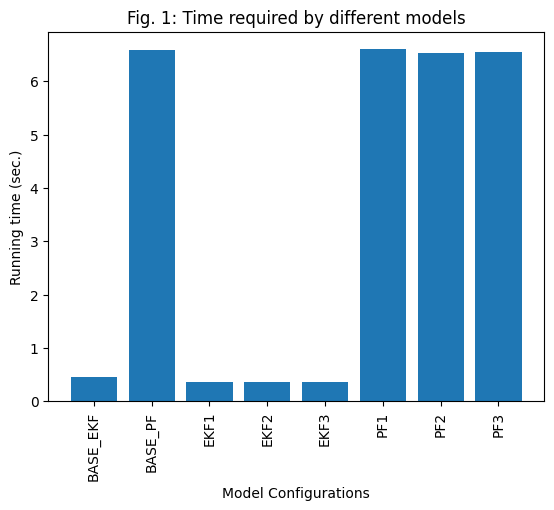

In [213]:
plt.bar(np.arange(errors['model_name'].nunique()), errors.groupby('model_name')['time'].mean())
plt.xticks(np.arange(errors['model_name'].nunique()), errors.groupby('model_name').groups.keys(), rotation=90)
plt.xlabel("Model Configurations")
plt.ylabel("Running time (sec.)")
plt.title("Fig. 1: Time required by different models")
plt.show()

In [263]:
errors.groupby('type')['time'].mean()['PF'] / errors.groupby('type')['time'].mean()['EKF']

16.904033586073663

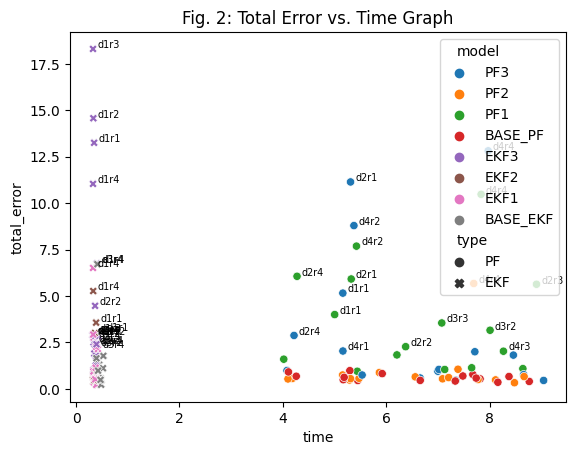

In [214]:
df = pd.DataFrame(zip(errors['acc?error']  + errors['max_error'] + errors['final_error'], errors['time'], errors['model_name'], errors['type'], errors['identifier']), columns = ['total_error', 'time', 'model', 'type', 'identifier'])
sns.scatterplot(df, hue='model', x='time', y='total_error', style='type')
for _, dfr in df.iterrows():
    if dfr['total_error'] > 2:
        plt.text(dfr['time']+0.09, dfr['total_error']+.05, dfr['identifier'], fontsize = 'x-small')
plt.title('Fig. 2: Total Error vs. Time Graph')
plt.show()

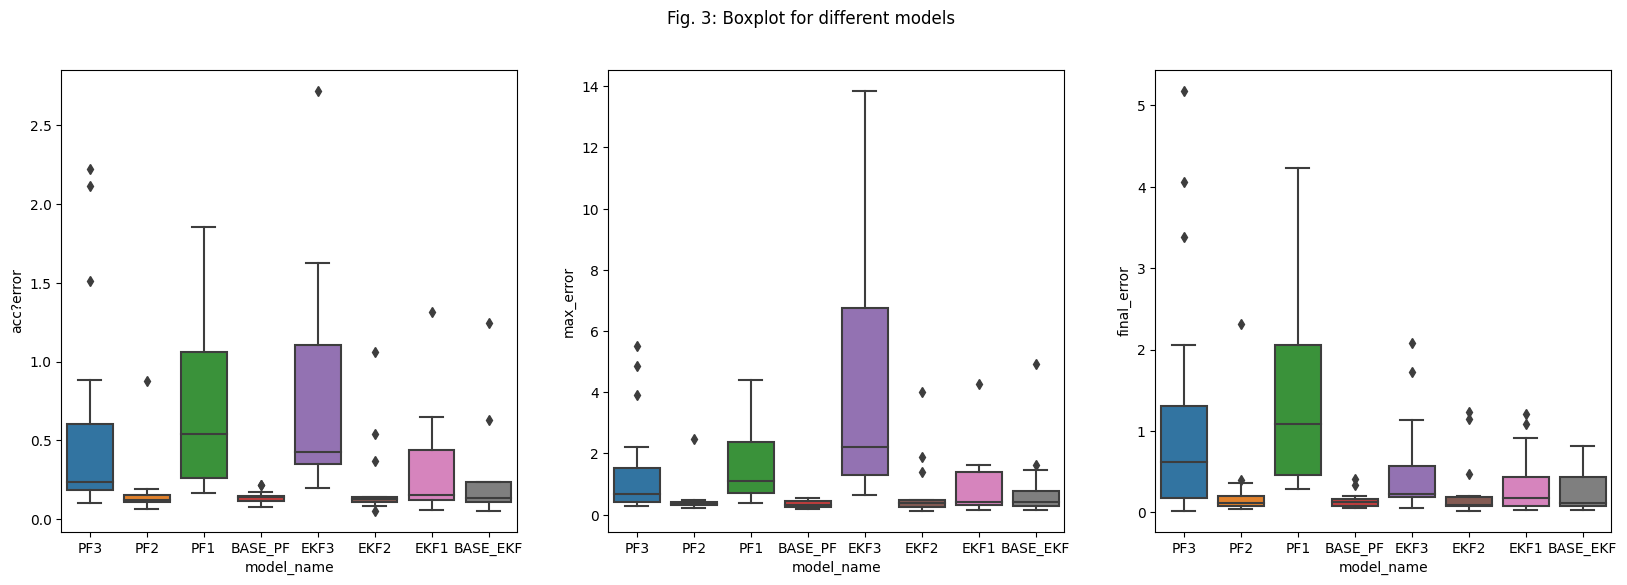

In [237]:
# Represent metrics for all experiments
f, axes = plt.subplots(1, 3, figsize=(20, 6))
sns.boxplot(errors, x='model_name', y='acc?error', ax=axes[0])
sns.boxplot(errors, x='model_name', y='max_error', ax=axes[1])
sns.boxplot(errors, x='model_name', y='final_error', ax=axes[2])

f.suptitle("Fig. 3: Boxplot for different models")
plt.show()

Fig. 4: Accumulated path error in different datasets


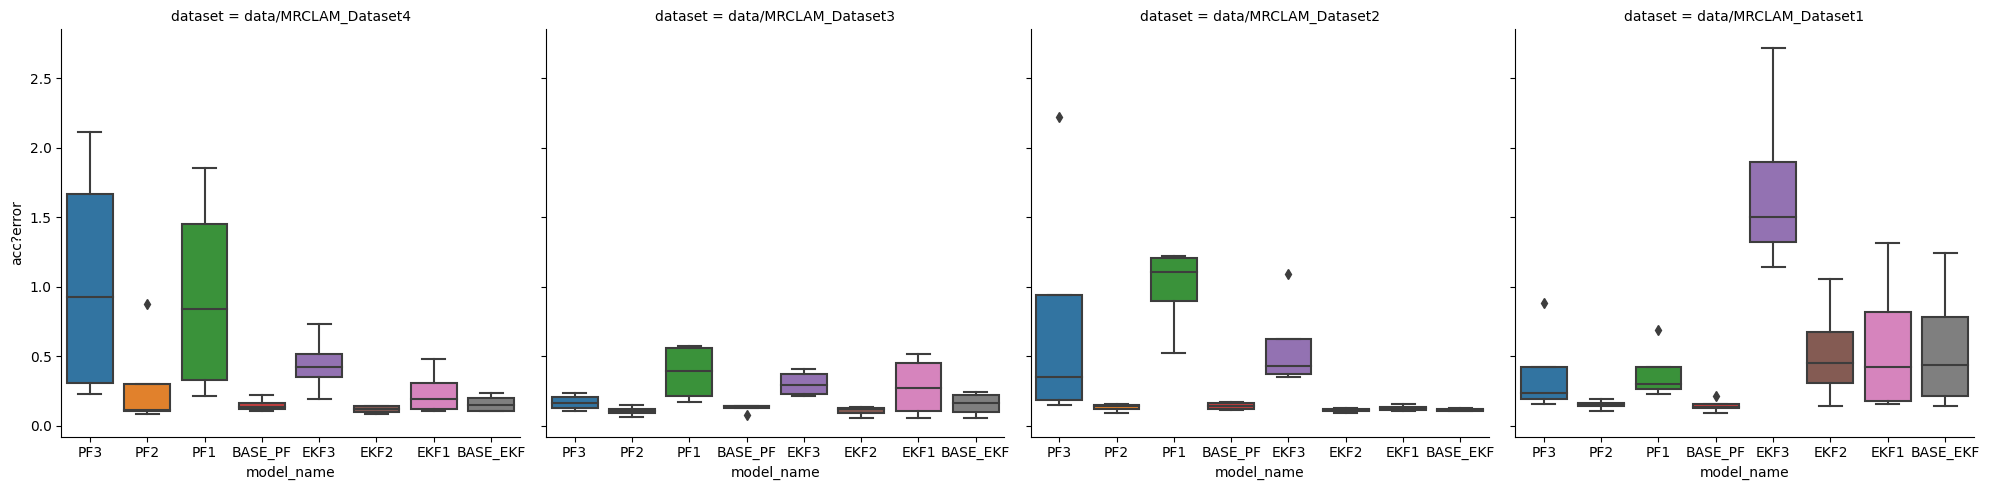

In [253]:
print("Fig. 4: Accumulated path error in different datasets")
sns.catplot(errors, x='model_name', y='acc?error', col='dataset', kind='box')
plt.show()

Fig. 5: Accumulated path error in different robots


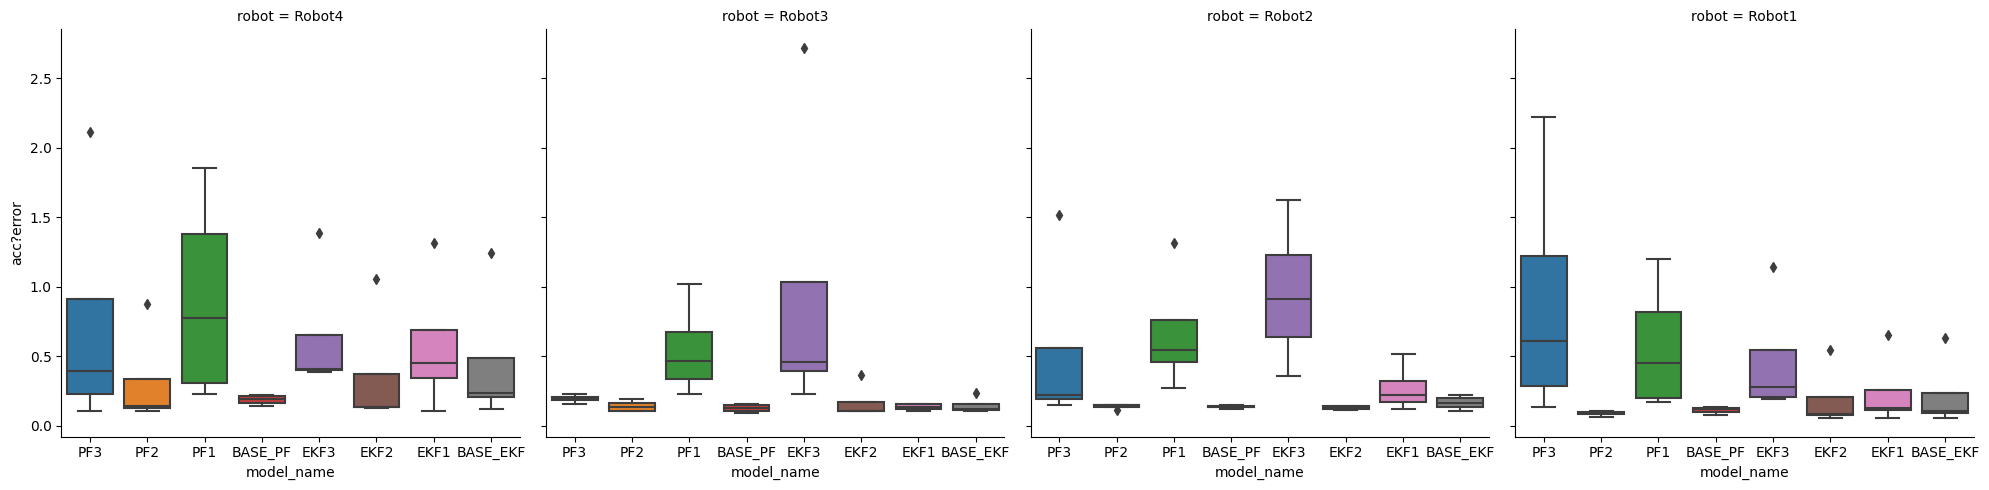

In [254]:
print("Fig. 5: Accumulated path error in different robots")
sns.catplot(errors, x='model_name', y='acc?error', col='robot', kind='box')
plt.show()

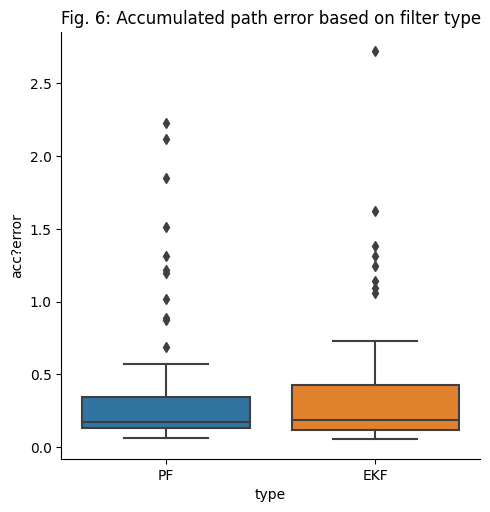

In [257]:
sns.catplot(errors, x='type', y='acc?error', kind='box')
plt.title("Fig. 6: Accumulated path error based on filter type")
plt.show()

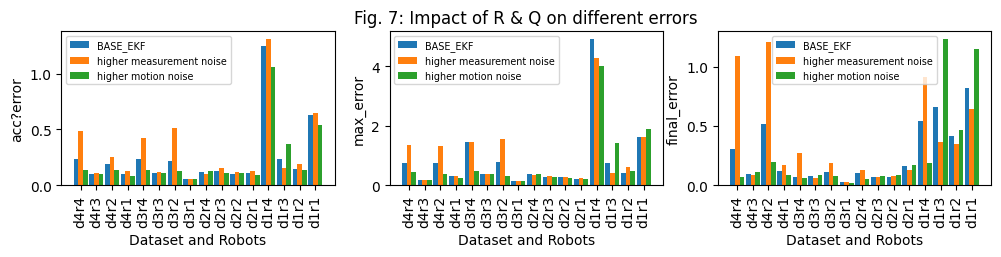

In [259]:
figure = plt.figure(figsize=(12,2))

width = 0.3
errs = ['acc?error', 'max_error', 'final_error']
for i in range(3):
    plt.subplot(130 + int(i) + 1)
    plt.bar(np.arange(len(errors[errors['model_name']=='BASE_EKF'])) - width, errors[errors['model_name']=='BASE_EKF'][errs[i]], width = width, label = 'BASE_EKF')
    plt.bar(np.arange(len(errors[errors['model_name']=='EKF1'])), errors[errors['model_name']=='EKF1'][errs[i]], width = width, label = 'higher measurement noise')
    plt.bar(np.arange(len(errors[errors['model_name']=='EKF2'])) + width, errors[errors['model_name']=='EKF2'][errs[i]], width = width, label = 'higher motion noise')
    plt.xticks(np.arange(len(errors[errors['model_name']=='EKF1'])), errors[errors['model_name']=='EKF1']['identifier'], rotation=90)
    plt.xlabel("Dataset and Robots")
    plt.ylabel(errs[i])
    plt.legend(fontsize='x-small')
    if i==1:
        plt.title("Fig. 7: Impact of R & Q on different errors")
plt.show()

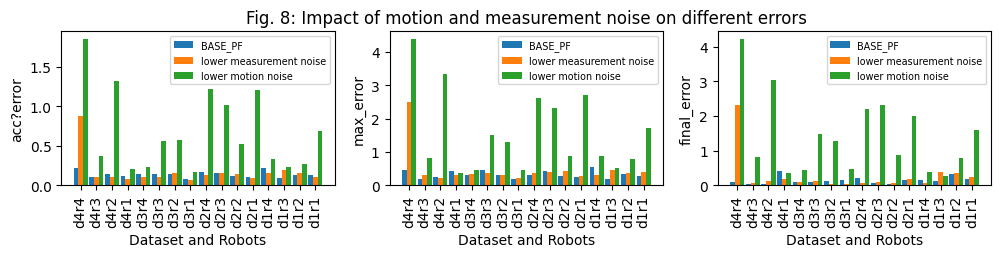

In [260]:
figure = plt.figure(figsize=(12,2))

width = 0.3
errs = ['acc?error', 'max_error', 'final_error']
for i in range(3):
    plt.subplot(130 + int(i) + 1)
    plt.bar(np.arange(len(errors[errors['model_name']=='BASE_PF'])) - width, errors[errors['model_name']=='BASE_PF'][errs[i]], width = width, label = 'BASE_PF')
    plt.bar(np.arange(len(errors[errors['model_name']=='PF2'])), errors[errors['model_name']=='PF2'][errs[i]], width = width, label = 'lower measurement noise')
    plt.bar(np.arange(len(errors[errors['model_name']=='PF1'])) + width, errors[errors['model_name']=='PF1'][errs[i]], width = width, label = 'lower motion noise')
    plt.xticks(np.arange(len(errors[errors['model_name']=='BASE_PF'])), errors[errors['model_name']=='BASE_PF']['identifier'], rotation=90)
    plt.xlabel("Dataset and Robots")
    plt.ylabel(errs[i])
    plt.legend(fontsize='x-small')
    if i==1:
        plt.title("Fig. 8: Impact of motion and measurement noise on different errors")
plt.show()

#### Analize metrics
**T3.1** Analize the representations, and extract some conclusions regarding the performance of each of the model configurations used. Which would be the best suited method for offline execution? Why?


<span style=color:red>**Answer:**</span> From Fig. 3, it can be observed that there are no significant discrepancies among the distributions of three different errors across all model configurations. The base particle filter (PF) model performs very similarly with a low error range in most cases, however, the base EKF has a wider range of errors including some outliers. The EKF2 and the PF2 configurations share the similarity of having slightly more confidence in the measurement model and, as a result, these produce comparatively accurate results, with lower median than the respective base models. PF1 (lower motion noise), PF3, and EKF3 are configurations with the widest overall error ranges. From Fig. 4, all the models perform uniformly for dataset 3 with low error variances. Similarly, for dataset 2, except the worse-performing configurations, other models can quite accurately estimate the states. Dataset 1 and 4 are more difficult to approximate through the filters. Fig. 5 shows the path error for different robots, where all configurations work particularly well for Robot 3.

Fig. 7 analyzes the impact of parameters R and Q of EKF, and for higher motion noise (R) the algorithm works more accurately (except d1r1, d1r3). Slightly more noise in the motion model improves the impact from the measurement model, hence, the reduced errors. Fig. 8 shows the impact of motion and measurement noises on the PF filter's accuracy, and almost in all cases, reduced noise in either causes more error.

**Offline Execution:**
From Fig. 6, we can see that the PFs produce a smaller box compared to the EKF including a lower median. Similarly, in Fig. 2 we can see both the base PF and PF2 can estimate states at a very low error rate in all cases. As in offline execution, computational requirements are not of concern, the PF is more suitable due to its accuracy. Besides, it can be further improved by tuning the number of particles.

**T3.2** Which would be the best suited method for online execution? Try to add the computation time as an extra metric for the assessment.

<span style=color:red>**Answer:**</span> Both the particle filter and EKF can be applied for online execution as both of them follows the markov assumption. However, in online settings, it is essential to estimate states rapidly at a lower computational cost. Observing Fig.2, although not as accurate, many EKF models can produce state estimations with very low total errors, much faster. Fig. 1 is the time graph that shows approximately all the PFs and EKFs take a similar time, but on average EKF is 17 times faster. Moreover, in PF the particles take some time to converge initially which is not the case for EFK. Hence, EKF is much more suitable in an online setting (EKF2 in this case) compared to PF.

**T3.3** BONUS. How would you modify the PF filter to allow filter initialization without prior state belief?

<span style=color:red>**Answer:**</span> Current implementation initializes the particle filter from the ground-truth initial state. Without this prior state belief, the particle states can be sampled from gaussian distributions with 0 mean. However, that results in high tracking error, and with enough particles, it takes a lot of time to converge. This delayed convergence can be helped by reinitializing all the particles after the first state estimation due to the measurement model. As a result, the particles are distributed closer to some observed positions which reduce the error.

In [ ]:
def state_update(self):
    # Update robot pos by mean of all particles
    state = np.mean(self.particles, axis = 0)
    self.states = np.append(self.states, np.array([[self.last_timestamp, state[0], state[1], state[2]]]), axis = 0)

    if self.first_measurement == 0:
        self.first_measurement += 1
        self.particles[:, 0] = np.random.normal(self.states[-1][1], self.motion_noise[0], self.num_particles)
        self.particles[:, 1] = np.random.normal(self.states[-1][2], self.motion_noise[1], self.num_particles)
        self.particles[:, 2] = np.random.normal(self.states[-1][3], self.motion_noise[2], self.num_particles)

        # Initial weights: set with uniform weights for each particle
        self.weights = np.full(self.num_particles, 1.0 / self.num_particles)

        # Initialize a variable to log particles
        self.particles_log = self.particles

time for 10 particle: 9.53 sec.


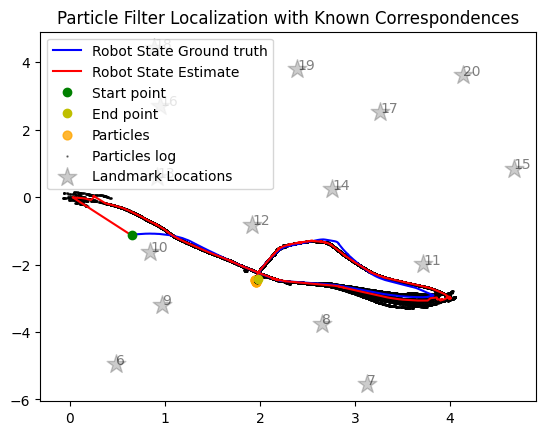

In [6]:
# Build Particle Filter object
num_particles = 10
motion_noise = np.array([0.1, 0.1, 0.1, 0.2, 0.2]) # Motion model noise [noise_x, noise_y, noise_theta, noise_v, noise_w]
measurement_noise = np.array([0.1, 0.1]) # Measurement model noise (in meters / rad) [noise_range, noise_bearing]
start = time.perf_counter()
pf = ParticleFilter(dataset, robot, end_frame, num_particles, motion_noise, measurement_noise)
print(f'time for {num_particles} particle: {time.perf_counter() - start:.2f} sec.')

### Delivery
Download the file in Notebook and Markdown formats to be uploaded in the Aula Digital.

To export the files go to File>Download as>Notebook and File>Download as>Markdown.

Save the files as **E1_name_surname.ipynb** and **E1_name_surname.md**

Compress files and figures in the same directory with the name **E1_name_surname.zip**